ALGORITMO DE LA TRANSFORMADA DE FOURIER

El análisis de Fourier es la herramienta fundamental en procesamiento de señales y resulta útil en otras áreas como en la resolución de ecuaciones diferenciales o en el tratamiento de imágenes.
La Transformada rápida de Fourier (FFT) es uno de los algoritmos más importantes en el procesamiento de señales y el análisis de datos.

La transformada discreta de Fourier

La FFT es un algoritmo rápido, para calcular la Transformada de Fourier Discreta (DFT).
El DFT, al igual que la versión continua más familiar de la transformada de Fourier, tiene una forma directa e inversa que se definen de la siguiente manera:

<img src="figure1.png",width=400,height=400 ALIGN=CENTER>


La transformación de xn → Xk es una traducción del espacio de configuración al espacio de frecuencia, y puede ser muy útil para explorar el espectro de potencia de una señal, y también para transformar ciertos problemas para un cálculo más eficiente.

# Calcular la FFT en Python desde cero.

## Transformada de Fourier Discreta (DFT)

La transformada inversa se puede implementar de una manera muy similar por lo que se opta por hacer solo la transformada directa. 

Observando la expresión DFT anterior, vemos que no es más que una operación lineal directa: una multiplicación matriz-vector de x⃗

X⃗ = M⋅x⃗ 

Con la matriz M dada por:

Mkn = e (−i 2π k n / N)

Con esto en mente, podemos calcular el DFT usando la multiplicación de matriz simple de la siguiente manera:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import pi

In [3]:
#Calcula la Transformada discreta de Fourier de la matriz 1D x

def DFT_slow(x):
    x=np.asarray(x, dtype=float)       # Convierte la entrada a una matriz.
    N=x.shape[0]                       # Tupla de las dimensiones de la matriz.
    n=np.arange(N)                     # Devuelve valores espaciados uniformemente dentro de un intervalo dado.
    k=n.reshape((N,1))                 # Da una nueva forma a una matriz sin cambiar sus datos.
    M=np.exp(-2j * np.pi * k * n / N)  
    return np.dot(M,x)                 # Producto punto de dos matrices.

Podemos verificar el resultado comparándolo con la función FFT incorporada de numpy:

In [4]:
x = np.random.random(1024)
np.allclose(DFT_slow(x), np.fft.fft(x))

True

### np.allclose

Devuelve **True** si dos arrays son equivalentes a los elementos dentro de una tolerancia.

Los valores de tolerancia son positivos, generalmente son números muy pequeños. La diferencia relativa (rtol * abs (b)) y la diferencia absoluta de atol se suman para comparar con la diferencia absoluta entre a y b.

Si cualquiera de las matrices contiene uno o más NaN, se devuelve **False**. Infs se tratan como iguales si están en el mismo lugar y con el mismo signo en ambas matrices.

Solo para confirmar la lentitud de nuestro algoritmo, podemos comparar los tiempos de ejecución de estos dos enfoques:

In [5]:
import timeit

Este módulo proporciona una manera simple de cronometrar pequeños bits de código Python. Tiene tanto una interfaz de línea de comando como una interfaz invocable. Evita una serie de trampas comunes para medir los tiempos de ejecución.

In [6]:
%timeit DFT_slow(x)
%timeit np.fft.fft(x)

1 loop, best of 3: 249 ms per loop
10000 loops, best of 3: 136 µs per loop


El algoritmo DFT es 10000 veces más lento, lo cual es de esperar para una implementación tan simplista.

### Simetrías en la Transformada de Fourier Discreta

Analíticamente una parte del problema está simplemente relacionada con otra, así que se puede calcular el subresultado sólo una vez y ahorrar ese coste computacional. Cooley y Tukey usaron exactamente este enfoque para derivar la FFT.

¿cuál es el valor de XN + k de la expresión anterior?:

<img src="figure2.png",width=350,height=350 ALIGN=CENTER>

donde se ha usado la identidad exp [2π i n] = 1 que vale para cualquier número entero n

X N + k = Xk.

Por una simple extensión,

X k+i⋅N = Xk

para cualquier número entero i. Esta simetría puede explotarse para calcular el DFT mucho más rápidamente.

## DFT a FFT: explotando la simetría

Cooley y Tukey mostraron que es posible dividir el cálculo DFT en dos partes más pequeñas. De la definición de DFT tenemos:

<img src="figure3.png",width=450,height=450 ALIGN=CENTER>


Se ha dividido la transformación de Fourier discreta en dos términos que a su vez se parecen mucho a las transformaciones discretas de Fourier más pequeñas, una en los valores impares y otra en los valores pares. Hasta ahora, sin embargo, no se ha guardado ningún ciclo computacional. Cada término consta de (N / 2) * N cálculos, para un total de N².

El truco consiste en hacer uso de las simetrías en cada uno de estos términos. Debido a que el rango de k es 0 ≤ k ≤ N, mientras que el rango de n es 0 ≤ n < M ≡ N/2, vemos a partir de las propiedades de simetría anteriores que solo necesitamos realizar la mitad de los cálculos para cada subproblema. Nuestro cálculo de [N²] se ha convertido en [M²], con M la mitad del tamaño de N.


Pero no hay razón para detenerse allí: siempre que las transformadas de Fourier más pequeñas tengan una M de valor par, se puede volver a aplicar este enfoque de dividir y vencer, reduciendo a la mitad el costo computacional cada vez, hasta que las matrices sean lo suficientemente pequeñas como para que la estrategia sea aplicada. Ya no es beneficioso en el límite asintótico, este enfoque recursivo se escala como [N log N].

Este algoritmo recursivo se puede implementar muy rápidamente en Python, reduciendo el lento código DFT cuando el tamaño del subproblema se vuelve adecuadamente pequeño.

In [7]:
def FFT(x):
    """Una implementación recursiva del 1D Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    
    if N % 2 > 0:
        raise ValueError("tamaño de x debe ser una potencia de 2")
    elif N <= 32:  # this cutoff should be optimized
        return DFT_slow(x)
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + factor[:N / 2] * X_odd,
                               X_even + factor[N / 2:] * X_odd])

Aquí haremos una comprobación rápida de que nuestro algoritmo produce el resultado correcto:

In [8]:
x = np.random.random(1024)
np.allclose(FFT(x), np.fft.fft(x))

True

Correlacionando este algoritmo con la versión lenta:

In [9]:
%timeit DFT_slow(x)
%timeit FFT(x)
%timeit np.fft.fft(x)

1 loop, best of 3: 250 ms per loop
100 loops, best of 3: 19 ms per loop
10000 loops, best of 3: 144 µs per loop


Hay que tener en cuenta que todavía no nos hemos aproximado a la velocidad del algoritmo de FFT incorporado en numpy, y esto es de esperar. El algoritmo FFT detrás de fft de numpy es una implementación de Fortran que ha recibido años de ajustes y optimizaciones.

Una buena estrategia para acelerar el código cuando se trabaja con Python / NumPy es vectorizar cálculos repetidos siempre que sea posible. Podemos hacer esto y, en el proceso, eliminar nuestras llamadas a funciones recursivas y hacer que nuestra FFT de Python sea aún más eficiente.

### Versión Vectorizada de Numpy

En la implementación de FFT recursiva anterior, en el nivel de recursión más bajo que realizamos N / 32
productos de matriz-vector idénticos. La eficiencia de nuestro algoritmo se beneficiaría al calcular estos productos de matriz vectorial de una sola vez como un solo producto matriz-matriz. En cada nivel subsiguiente de recursión, también realizamos operaciones duplicadas que pueden ser vectorizadas. NumPy sobresale en este tipo de operación, y podemos hacer uso de ese hecho para crear esta versión vectorizada de la Transformada Rápida de Fourier:

In [10]:
def FFT_vectorized(x):
    """Una versión vectorizada, no recursiva de la FFT Cooley-Tukey"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]

    if np.log2(N) % 1 > 0:
        raise ValueError("tamaño de x debe ser una potencia de 2")

    # N_min aquí es equivalente a la condición de detención anterior,
    # y debería de ser una potencia de 2
    N_min = min(N, 32)
    
    # Realice un O[N^2] DFT en todos los sub-problemas longitud-N_min a la vez
    n = np.arange(N_min)
    k = n[:, None]
    M = np.exp(-2j * np.pi * n * k / N_min)
    X = np.dot(M, x.reshape((N_min, -1)))

    # acumular cada nivel del cálculo recursivo todo a la vez.
    while X.shape[0] < N:
        X_even = X[:, :X.shape[1] / 2]
        X_odd = X[:, X.shape[1] / 2:]
        factor = np.exp(-1j * np.pi * np.arange(X.shape[0])
                        / X.shape[0])[:, None]
        X = np.vstack([X_even + factor * X_odd,
                       X_even - factor * X_odd])

    return X.ravel()

Aunque el algoritmo es un poco más complicado, es simplemente una reorganización de las operaciones utilizadas en la versión recursiva con una excepción: se explota una simetría en el cálculo de factores y construimos solo la mitad de la matriz. De nuevo, confirmaremos que nuestra función arroja el resultado correcto:

In [13]:
x = np.random.random(1024)
np.allclose(FFT_vectorized(x), np.fft.fft(x))

True

Debido a que nuestros algoritmos son cada vez más eficientes, podemos usar una matriz más grande para comparar los tiempos, dejando fuera DFT_slow:

In [14]:
x = np.random.random(1024 * 16)
%timeit FFT(x)
%timeit FFT_vectorized(x)
%timeit np.fft.fft(x)

1 loop, best of 3: 313 ms per loop
100 loops, best of 3: 11.2 ms per loop
1000 loops, best of 3: 1.92 ms per loop


el algoritmo de FFT propuesto por Cooley-Tukey se puede ampliar para usar divisiones de tamaño distinto de 2 (lo que se ha implementado aquí se conoce como radix-2 Cooley-Tukey FFT). Además, se pueden usar otros algoritmos de FFT más sofisticados, que incluyen enfoques fundamentalmente distintos basados en convoluciones.

# Implementación práctica del algoritmo propuesto

In [15]:
iris = pd.read_csv('sismograma.csv')

In [16]:
tiempo=iris['tiempo']
sism=iris['sismograma_dtco']

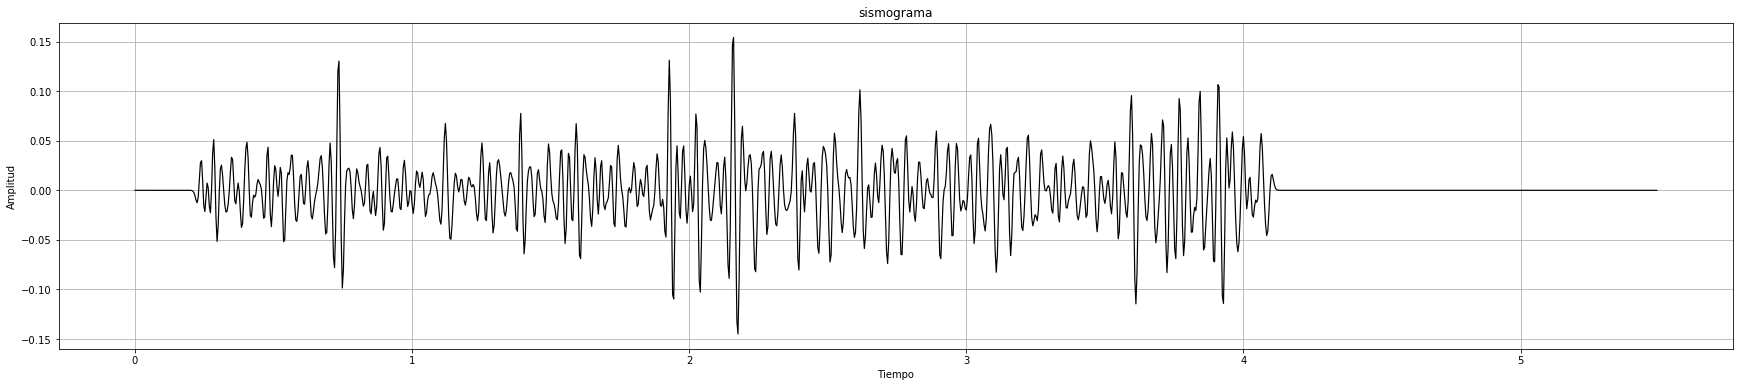

In [17]:
plt.figure(figsize=(30,6))
plt.plot(tiempo,sism,'k',linewidth=1.2)
plt.title('sismograma')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

In [18]:
FtraV=DFT_slow(sism)

/home/acer/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


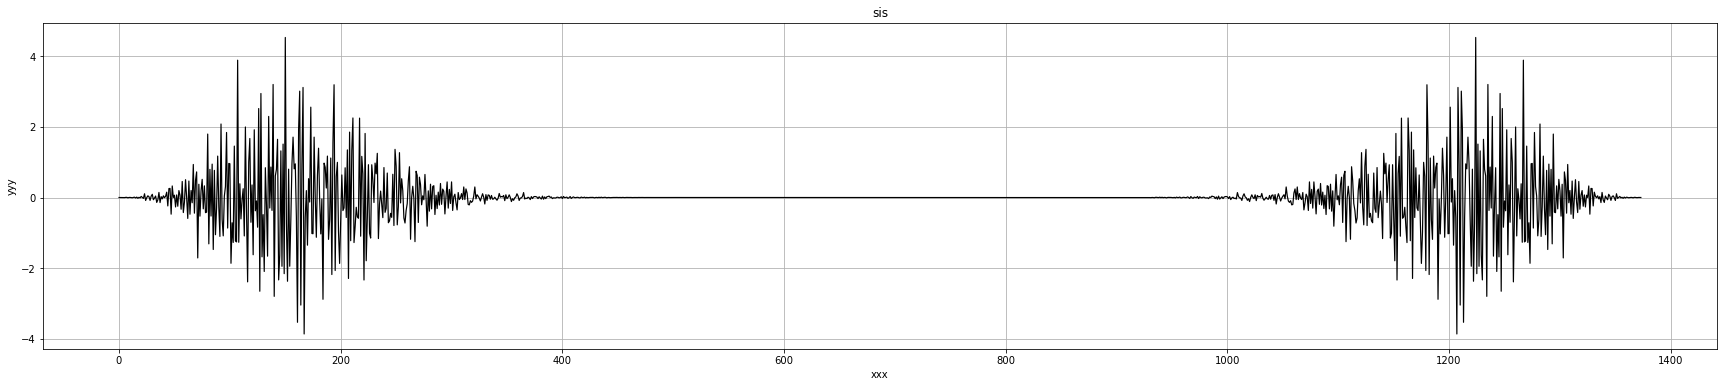

In [19]:
plt.figure(figsize=(30,6))
plt.plot(FtraV,'k',linewidth=1.2)
plt.title('sis')
plt.xlabel('xxx')
plt.ylabel('yyy')
plt.grid()
plt.show()

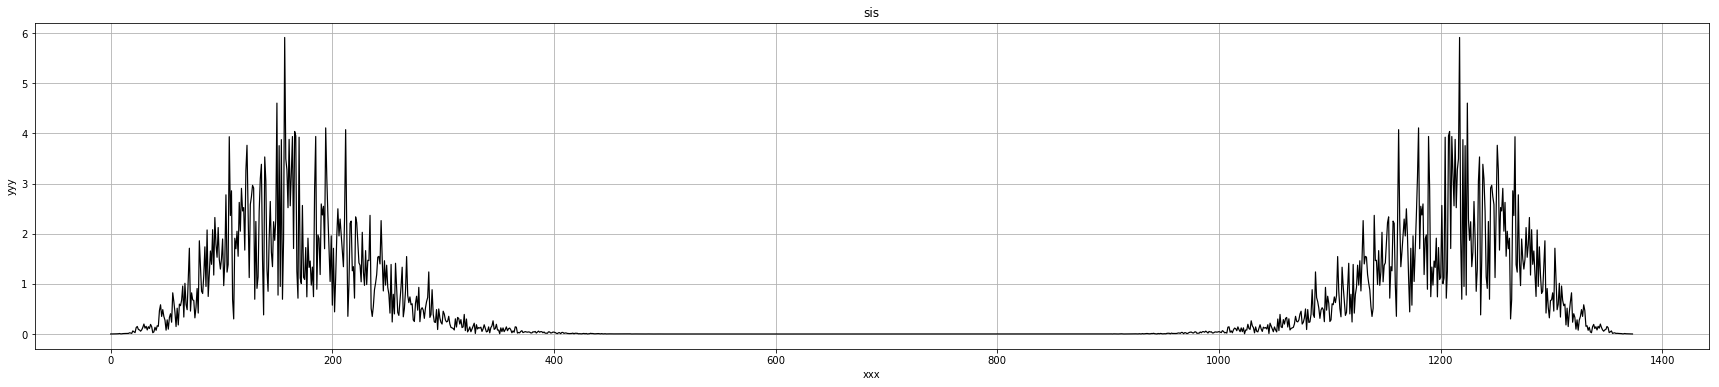

In [20]:
Fabs=abs(FtraV)

plt.figure(figsize=(30,6))
plt.plot(Fabs,'k',linewidth=1.2)
plt.title('sis')
plt.xlabel('xxx')
plt.ylabel('yyy')
plt.grid()
plt.show()

In [21]:
Ff= Fabs[0:len(sism)/2]

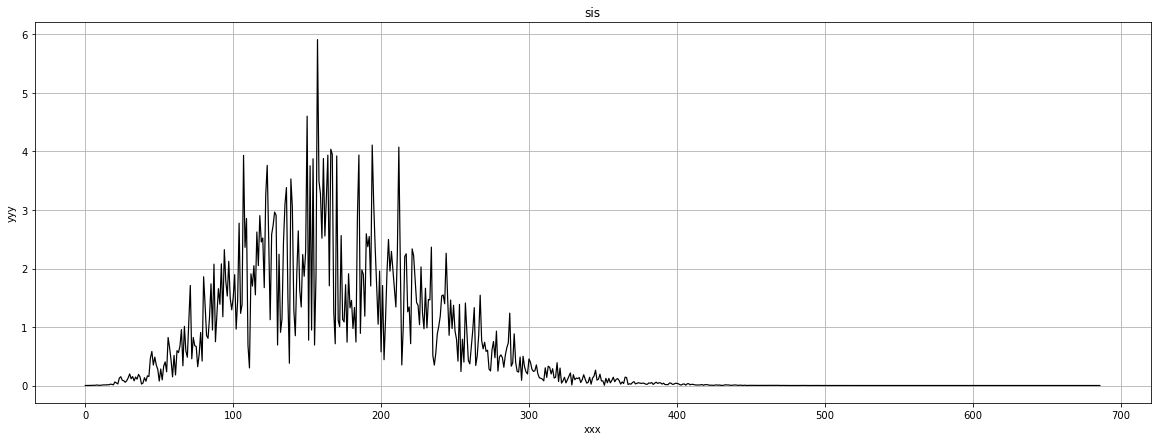

In [22]:
plt.figure(figsize=(20,7))
plt.plot(Ff,'k',linewidth=1.2)
plt.title('sis')
plt.xlabel('xxx')
plt.ylabel('yyy')
plt.grid()
plt.show()

In [23]:
freq=np.arange(0,687,1)*(250./len(FtraV))

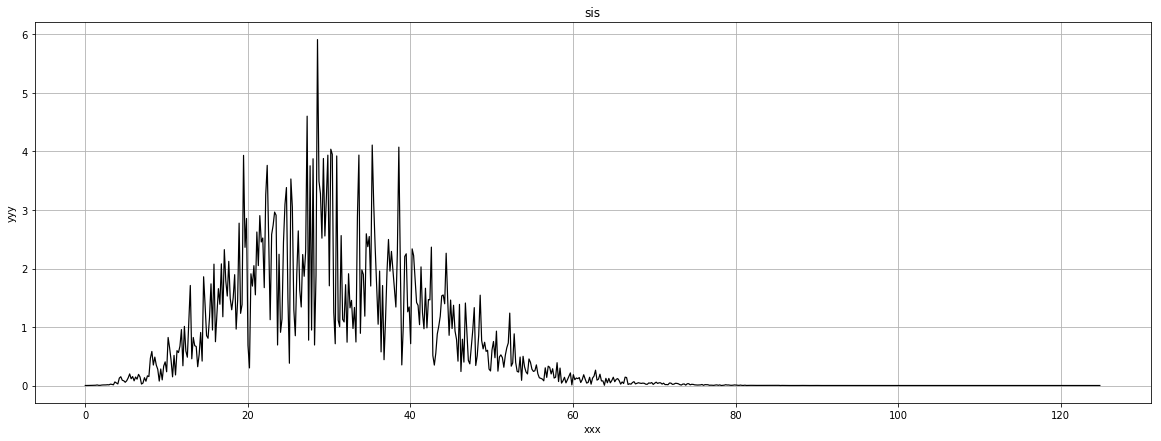

In [24]:
plt.figure(figsize=(20,7))
plt.plot(freq,Ff,'k',linewidth=1.2)
plt.title('sis')
plt.xlabel('xxx')
plt.ylabel('yyy')
plt.grid()
plt.show()

## Referencias

https://gist.github.com/Derog/c73a2a68a60fcd53f16a

https://ccrma.stanford.edu/%7Ejos/mdft/Spectrum_Analysis_Sinusoid_Windowing.html

https://pybonacci.es/2012/09/29/transformada-de-fourier-discreta-en-python-con-scipy/

http://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/

http://www.ams.org/journals/mcom/1965-19-090/S0025-5718-1965-0178586-1/S0025-5718-1965-0178586-1.pdf